<div style="text-align: left">
<a href="http://www.datascience-paris-saclay.fr"><img src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="70%"></a>
</div>

# [RAMP](https://www.ramp.studio/problems/) on Melanomas detection and prevention

Authors : 
_Jean Babin, Victorien Gimenez , Vincent Jacob, Cyril Equilbec_

1. [Introduction](#Introduction)
    1. The predictive task
    2. Quantitative score and prediction value (quantitave scores)
    3. Expected usage of the predictor
2. [Data](#Data)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction

Skin diseases are very common, especially melanoma and require full attention. Indeed, the statistics are striking : Melanoma skin cancer is the 5th most common cancer in the UK, accounting for 4% of all new cancer cases (2015). 
1 person dies of melanoma every hour in North America, 1 out of 5 people in the USA will eventually contract a skin cancer during their lifetime and an interesting fact motivating our challenge : 70% of skin cancers are first detected by the patients themselves or their relatives.

Skin cancer is a major problem but unfortunately underestimated : too few people regularly consult a dermatologist, which can be understood because getting an appointment can be really long.

However, several initiatives have been launched to simplify the prevention of this disease, including the [Molescope](https://molescope.com/) smartphone application that allows the user to take a picture of your mole with a special physical device and share it with a dermatologist. This is a great initiative but it can be restrictive as you have to buy an extra device and wait for the dermatologist to send its feedback. 

This is why we propose to use data science to build a strong classifier able to distinguish between benign moles, moles suspicious enough to require a profesionnal point of view for further examinations and already dangerous moles which require immediate attention.
This classifier should be used as a part of a fully automated smartphone application which basically will allow the user to take a snapshot of one of his mole and get instant feedback.

A good prediction could lead to a significant improvement in the prevention of melanoma.


### The prediction task

This challenge proposes to design the best algorithm to detect suspicious and potentially dangerous beauty spots from an extensive database mostly created from the [Isic archive](https://www.isic-archive.com/?fbclid=IwAR1z5lIE-A_zGL1ewbxjQG6Q7AfRq4mgIsRO_afgb6jVFpVK2f0ittcHHWI#!/onlyHeaderTop/gallery) and the [Addi project](http://www.fc.up.pt/addi/project.html)  containing a thousand 1022 ☓ 767 pixels verified and colored pictures of moles representing different stages of the disease or innocuous moles.

After sorting and selecting the most relevant samples, we give to the users a subset of this large dataset in order to test and calibrate their algorithms. 


![title](img/mole.png)
<div style="text-align: center">Example of a mole given in the dataset</div>


We provide a dataset already rescaled to 400 ☓ 400 pixels images and into grayscale by averaging the RGB channels and rescaling the picture using scikit learn library. 


![title](img/outfile.jpg)
<div style="text-align: center">Rescaled picture of a mole</div>

Using an appropriate metric, we will compare the true solution to the estimation. The goal is to provide detection of more than 90% moles suspicious enough to require further examinations by a dermatologist with a minimum number of false negative. If the objective is met, the next step would be to enhance the data base with amateur photos to improve the reliability of the classifier in real situations, unfortunately, those photos are difficult to gather. 

## Data

### From raw data to local quadrangles

The full THEMIS map of Mars has been saved in a cylindrical projection.    Raw visualization of the full map is thus quite difficult.

<img src="img/full_image.png" width="80%">
<div style="text-align: center">Raw THEMIS data</div>

In order to correct for the distortions and recover the circularity of the craters, the map has to be reprojected locally. For that, we use a partitions known as _quadrangles_. 140 quadrangles are used to cover the whole Mars surface from which we selected some (the colored quadrangles) for this exercice.

<img src="img/train_test_quadrangles.png" width="95%">
<div style="text-align: center">
Longitude vs latitude quadrangle division in the raw THEMIS projection.<br/>
Challenge datasets have been constructed using random patches from these quadrangles.<br/>
Numbers indicate quadrangle IDs and colors refer to the train/test and public/private distinction.
</div>

We use the boundaries of the quadrangle to extract the relevant pixels from the raw THEMIS map (above). Here we choose the quadrangle #77, close to the equator, and thus only slightly distorted.

<img src="img/quad_77_original_small.png" width="80%">
<div style="text-align: center">Quadrangle 77</div>

Then we reproject the pixels to the local stereographic projection in order to correct for the distortions. The result can be seen below.

<img src="img/quad_77_localstereo_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected</div>

For illustration, we use the crater database to project the labeled craters per category on the reprojected map.

<img src="img/quad_77_local_craters_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected with labelled craters</div>

### From quadrangles to input data

After selecting a common **shape for the input** of image processing models **224x224**, we start from the reprojected quadrangles and decide to create the patches from a tiling with overlap to cover the craters falling on the edges. The tiling is also performed on downsampled versions of the quadrangles, until all craters can be detected for all sizes of craters present.
With the current set up, the **craters** contained in every image **have radii** that span the range **of 5 to 28 pixels**.

With no further do, let's have a look at the data.

### Required dependencies and downloads

#### Installation of libraries and `ramp-workflow`

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://conda.io/miniconda.html). 

In [1]:
# !conda env create -f environment.yml   # use the environment.yml file to create the 'mars-craters' env
# !source activate mars-craters          # activate the virtual environment

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [2]:
# !pip install -r requirements.txt

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~700Mb of images.

In [ ]:
#!pip install googledrivedownloader
#!python download_data.py

### The input data

In [2]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
X_train =  np.load("./data/data_train.npy")
X_test =  np.load("./data/data_test.npy")

print("The training data is made of {} images of {} x {} pixels".format(
    *X_train.shape))

print("The test data is made of {} images of {} x {} pixels".format(
    *X_test.shape))

n_img = len(X_train)

The training data is made of 619 images of 400 x 400 pixels
The test data is made of 120 images of 400 x 400 pixels


Here we display 3 randomly select images. You can play around with the values.

In [5]:
idx_list = [30, 400, 519]

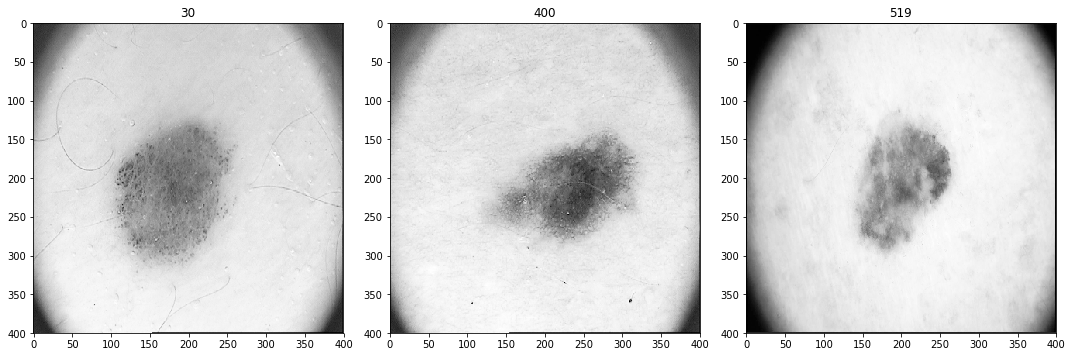

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title('%d' % idx)
fig.tight_layout()

In [7]:
df = pd.read_csv("./data/data_train_labels.csv")
ff = pd.read_csv("./data/data_test_labels.csv")
y_train = np.array(df["label"])
y_test = np.array(ff["label"])

In [10]:
df.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


The labels consist of a `pandas.DataFrame` containing the list of images. For each images, the columns are
- `id`: index of the image it belongs to
- `label` : if it's benign (0) or not (1)

Let's visualize some.

# EDA DE JEAN à PLUG ICI

### Label distribution

#### Individual craters

In [17]:
print("There are {} labeled craters in the training set.".format(y_train.size))

There are 38344 labeled craters in the training set.


#### Lots of "empty" images

In [20]:
n_img_withcraters = y_train['i'].unique().size

print("There are labeled craters in only {:.1%} of the images.".format(
    n_img_withcraters / n_img))

There are labeled craters in only 51.0% of the images.


Text(0.5,1,'Crater radius frequency for the training data')

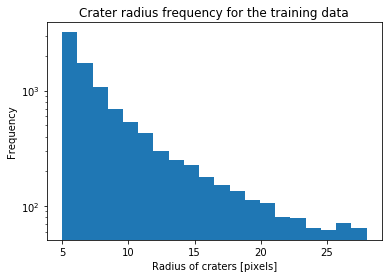

In [21]:
y_train.radius_p.plot(kind='hist', bins=20, log=True)
plt.xlabel('Radius of craters [pixels]')
plt.title('Crater radius frequency for the training data')

# EXPLICATION DE LA PIPELINE ML ICI

## The pipeline

<img src="img/workflow.svg" width="70%">

For submitting at the [RAMP site](http://ramp.studio), you will have to write an `ObjectDetector` class in a file named `object_detector.py` that will handle the training and prediction .

### Object detector

A dummy object detector which detects a single crater in the middle of each patch.

In [23]:
%load submissions/starting_kit/object_detector.py

Format of the data it receives:

In [24]:
import problem

In [25]:
X, y = problem.get_train_data()

In [26]:
X.shape

(9000, 224, 224)

A single image patch:

In [27]:
X[0].shape

(224, 224)

The corresponding ground thruth data for that patch consists of a list of tuples (x, y, radius):

In [28]:
y[0]

[(154.0, 51.0, 15.75)]

In [29]:
y[2]

[(46.0, 47.0, 6.7000000000000002),
 (85.0, 176.0, 5.1500000000000004),
 (21.0, 156.0, 8.5),
 (150.0, 95.0, 10.6),
 (116.0, 105.0, 9.0999999999999996),
 (38.0, 13.0, 6.25),
 (56.0, 115.0, 5.2999999999999998)]

In [30]:
y[4]

[(122.0, 122.0, 10.199999999999999)]

The format returned by the `predict` method contains one extra element: the confidence or score for that predicted crater: `(conf, x, y, radius)`. The returned value in `predict` should then be an array of lists of tuples.

# EXPLICATION METRIQUES VINCENT ICI 

### Scoring

`y_true` and `y_pred` can have variable length

- What is a detection ?
- What is the distance between two lists of predictions ?
- How do we rank the various models ?


#### Intersetion over Union : IoU

Distance in (x, y, r) space computed using IoU (adapted for circles in this problem)

<img src="img/iou_formula.png" width="30%">
<img src="img/iou_examples.png" width="70%">

Detection can start at `IoU > 0` but traditionally an object is detected if **`IoU > 0.5`**.

#### Confidence level

Each prediction should be associated with a confidence, so that they can be ranked. The confidence value should be the first one that appears, before `x, y, radius`.

#### Matching

The Hungarian method [$O(N log(N))$] is used to compute the best match between the true and predicted list.

### Metric #1 Average Precision

- **precision**: fraction of correct predictions
- **recall**: fraction of true objects that are predicted

Precision and recall are computed as a function of the confidence value threshold to produce the mean Average Precision (mAP) curve.

<img src="img/precision-recall-curve.png" width="70%">


### Metric #2 OSPA

[OSPA](http://www.dominic.schuhmacher.name/papers/ospa.pdf) is a miss-distance between the best match of two variable size lists of objects. It penalizes the both the distance between the best match entries and the size difference, referred to as _cardinality_.

The distance used here is the IoU for circles.

<img src="img/ospa_figure2.png" width="80%">
<div style="text-align: center">Various examples of sets of entries and their corresponding OSPA value.</div>

### Metric #3 SCP

_Superposed Cylinders and Prisms_ is a new score based on the projection of true and predicted craters on a rasterized image (mask). Its advantage is that it is a pixelwise score that involves no combinatorial pairing of true and detected objects, so it can be differentiated wrt detected objects.

For each object of bounding area $A$ (circle or polygon), we construct a volume  with height $1/A$, so each object is represented by a 3D function, a cylinder or prism of volume 1. We then superimpose all true and predicted objects to obtain $f_\text{true}(pixel)$ and $f_\text{true}(pixel)$, and integrate their differences. Each crater missed completely or predicted where there is no crater adds 1 to the distance. Detected but misaligned craters add a score between zero and two, approximating $2 \times IoU$ to a certain extent. The maximum of $\int f_\text{true}(p) - f_\text{pred}(p) \text{d}p$ is the sum of true and detected craters, so to bring the SCP score into $[0, 1]$, we divide the integral by this sum.

<img src="img/det_mask.png" width="65%">

## Some points when building the model

<div class="alert alert-danger">

 <ul>
  <li>In the ground truth, **we only label craters of radius 5 to 28 pixels**. You should make sure that your model also only predicts craters in this range, otherwise it will be penalized for finding (possibly existing) craters not present in the ground truth.</li>
  <li>All metrics, except for Average Precision, are calculated by selecting the set of predictions based on a **confidence threshold of 0.5**. So you should **rescale the returned value of the confidence** so that the best threshold for your model is rescaled to 0.5.</li>
  <li>The data for training and testing comes from different quadrangles of Mars, and can different characteristics (different lightning angle, different image quality, ..). This means it will be important to make the model robust to that (e.g. by randomly flipping the images).</li>
</ul> 

</div>

# Image processing example

# Deep net example

**Deep learning for image classification**


The starting kit contains a `keras ConvNet` example, using a basic implementation adapted from the [official documentation.](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

Some characteristics of the Convolutional Neural Net:

- Set of convolutional layers which apply a convolution operation to the input, passing the result to the next layer. *The convolution emulates the response of an individual neuron to visual stimuli.*
- Set of pooling layers which combine the outputs of neuron clusters at one layer into a single neuron in the next layer. *For example, average pooling compute the average value from each of a cluster of neurons at the prior layer.*
- Flatten and fully connected layers, used to convert the 3D feature maps computed with the previous layers to 1D feature vector and make binary classification.

The general architecture for classification task is given below : 


![ConvNet](img/convnet_archi.jpg)

First load the data, then the data has to be rescaled in the range $[0,1]$: 

In [13]:
from problem import get_train_data

X_train_origin, y_train_origin = get_train_data()
X_test_origin, y_test = get_train_data()

In [14]:
print("Shape of training set : {}".format(X_train_origin.shape))

Shape of training set : (619, 160000)


In [15]:
X_train_origin /= 255
X_test_origin /= 255

By default, the dataset is a pandas Dataframe. For convenience, we'll transform it into a numpy array.

In [16]:
type(X_train_origin)

pandas.core.frame.DataFrame

In [17]:
X_train_origin = X_train_origin.values
X_test_origin = X_test_origin.values

type(X_train_origin)

numpy.ndarray

One specificity of this ConvNet implementation is that the images have to be reshaped to include the channel :

In [18]:
X_train_origin = X_train_origin.reshape(-1, 400, 400, 1)
X_test_origin = X_test_origin.reshape(-1, 400, 400, 1)

In [19]:
print("Shape of training set : {}".format(X_train_origin.shape))

Shape of training set : (619, 400, 400, 1)


In order to fasten the computation, we can downscale the images : 

In [20]:
from skimage.transform import resize

X_train = np.array([resize(image, (128, 128, 1), mode='reflect', anti_aliasing=True) for image in X_train_origin])
X_test = np.array([resize(image, (128, 128, 1), mode='reflect', anti_aliasing=True) for image in X_test_origin])

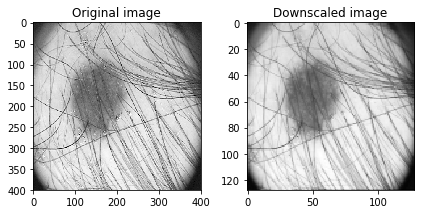

In [30]:
plt.subplot(121)
plt.imshow(X_train_origin[0].reshape(400, 400), cmap='Greys_r')
plt.title("Original image")


plt.subplot(122)
plt.imshow(X_train[0].reshape(128, 128), cmap='Greys_r')
plt.title("Downscaled image")
plt.tight_layout()
plt.show()

Our model follows the architecture described above, it contains 3 convolutionnal layers with relu activation and their associated max pooling layers, the classification task will be performed by a fully connected layer with hyperbolic tangent activation and an output layer with sigmoid activation (because we're in the case of binary classification). A dropout layer is also implemented to prevent overfitting in the training phase (by randomly *killing* a fraction rate of input units at each update).

An overall summary of our model is given here :

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, MaxPooling2D, Conv2D, Flatten

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(0.55))
model.add(Dense(1))
model.add(Activation('sigmoid'))


print(model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

Let's run our model and see how it does on our dataset : 

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
batch_size = 32

model.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1)

Epoch 1/25
619/619 [==============================] - 8s 13ms/step - loss: 0.7205 - acc: 0.4992
Epoch 2/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6861 - acc: 0.5638
Epoch 3/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6693 - acc: 0.6026
Epoch 4/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6479 - acc: 0.6058
Epoch 5/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6231 - acc: 0.6462
Epoch 6/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6308 - acc: 0.6721
Epoch 7/25
619/619 [==============================] - 7s 12ms/step - loss: 0.6063 - acc: 0.6543
Epoch 8/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6120 - acc: 0.6656
Epoch 9/25
619/619 [==============================] - 7s 11ms/step - loss: 0.6017 - acc: 0.6931
Epoch 10/25
619/619 [==============================] - 7s 11ms/step - loss: 0.5907 - acc: 0.6834
Epoch 11/25
619/619 [==================

After 25 epochs, our model has reached 83% of accuracy in the training phase. Let's see how it performs on test data : 

In [41]:
y_pred = model.predict_classes(X_test)

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68        51
           1       0.80      0.58      0.67        69

   micro avg       0.68      0.68      0.68       120
   macro avg       0.69      0.69      0.67       120
weighted avg       0.71      0.68      0.67       120



### Conclusion and tips :

Our model seems to not overfit thank's to the aggressive Dropout strategy, it seems also to have a good precision on detecting abnormal moles but there is still plenty of room left for improvement !

In deep learning, the amount of data is crucial, one idea of improvement would be to use data augmentation techniques. Another idea would be to let the model runs for many more epochs or to improve the architecture of the model. Also, the downscale strategy might have been too aggressive. 

Plotting the predictions and some scores:

In [77]:
from rampwf.score_types.detection import (AverageDetectionPrecision, 
                                          DetectionPrecision, 
                                          DetectionRecall, 
                                          SCP)

In [79]:
average_precision = AverageDetectionPrecision()
precision = DetectionPrecision()
recall = DetectionRecall()
scp = SCP(shape=(224, 224), minipatch=[56, 168, 56, 168])
scp(y_test[:n_prefix], y_pred)

0.71396393011532211

In [87]:
average_precision(y_test[:n_prefix], y_pred)

0.35963751739159838

In [82]:
precision(y_test[:n_prefix], y_pred)

0.52631578947368418

In [83]:
recall(y_test[:n_prefix], y_pred)

0.2857142857142857

Those number depend on the confidence threshold:

In [99]:
ps = []
rs = []
scps = []

for conf_threshold in np.linspace(0, 1, 50):
    ps.append(precision(
        y_test[:n_prefix], y_pred, conf_threshold=conf_threshold))
    rs.append(recall(
        y_test[:n_prefix], y_pred, conf_threshold=conf_threshold))
    scps.append(scp(
        y_test[:n_prefix], y_pred, conf_threshold=conf_threshold))
    
ps = np.array(ps)
rs = np.array(rs)
scps = np.array(scps)

Precision-recall curve:

Text(0.7,0.8,'AP = 0.36')

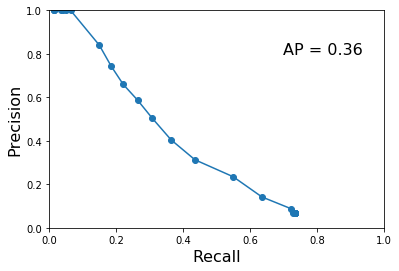

In [100]:
ap = average_precision(y_test[:n_prefix], y_pred)
fig, ax = plt.subplots()
ax.plot(rs, ps, 'o-')
ax.set_xlabel('Recall', fontsize=16)
ax.set_ylabel('Precision', fontsize=16)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.text(0.7, 0.8, 'AP = {:.2f}'.format(ap), fontsize=16)

SCP, precision, and recall in function of the confidence threshold:

In [101]:
conf_thresholds = np.linspace(0, 1, 50)

Text(0.7,0.8,'min(SCP) = 0.69')

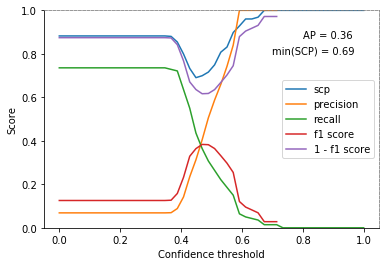

In [102]:
fig, ax = plt.subplots()
ax.plot(conf_thresholds, scps, label='scp')
ax.plot(conf_thresholds, ps, 'C1', label='precision')
ax.plot(conf_thresholds, rs, 'C2', label='recall')
ax.plot(conf_thresholds, 2*(ps * rs) / (ps + rs) , 'C3', label='f1 score')
ax.plot(conf_thresholds, 1 - 2*(ps * rs) / (ps + rs) , 'C4', label='1 - f1 score')

ax.legend(loc=7)

ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Score")

ax.set_ylim(0, 1)

#ax.axhline(1, linestyle='--', color='grey')
#ax.axvline(conf_thresholds[17], color='grey', linestyle='--')
ax.spines['top'].set(linestyle='--', color='grey')
ax.spines['right'].set(linestyle='--', color='grey')
    
ax.text(0.8, 0.87, 'AP = {:.2f}'.format(ap))
ax.text(0.7, 0.80, 'min(SCP) = {:.2f}'.format(np.min(scps)))

## Local testing/exploration

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

Check list

- Make sure you have installed `ramp-workflow` locally (see [above](#Installation-of-ramp-workflow))
- Make sure that the python files `object_detector.py` is in the  `submissions/your_submission` folder, and the train and test data are in [`data`](/tree/data)
- If you haven't yet, download the images by executing 
  ```
  python download_data.py
  ```

Finally, make sure the local processing goes through by running the

```
ramp_test_submission --submission your_submission
```

If you want to quickly test the that there are no obvious code errors, use the `--quick-test` keyword to only use data from the first 30 images. 

```
ramp_test_submission --submission your_submission --quick-test
```

In [103]:
!ramp_test_submission --quick-test

Testing Mars craters detection and classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
Couldn't re-order the score matrix..
	score   ap  madc  madr   ospa  ...    rec(0)  rec(0.5)  rec(0.9)    scp
	step                           ...                                     
	test   0.0   NaN   NaN  0.989  ...     0.514       0.0       0.0  0.991
	train  0.0   NaN   NaN  0.995  ...     0.647       0.0       0.0  0.995
	valid  0.0   NaN   NaN  0.991  ...     0.714       0.0       0.0  0.994
CV fold 1
Couldn't re-order the score matrix..
	score   ap  madc  madr   ospa  ...    rec(0)  rec(0.5)  rec(0.9)    scp
	step                           ...                                     
	test   0.0   NaN   NaN  0.989  ...     0.514       0.0       0.0  0.991
	train  0.0   NaN   NaN  0.994  ...     0.786       0.0       0.0  0.995
	valid  0.0   NaN   NaN  0.992  ...     0.500       0.0       0.0  0.993
CV fold 2
Couldn't re-orde

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio). First, if it is your first time using RAMP, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then find an open event on the particular problem, the event [mars_craters](https://www.ramp.studio/events/mars_craters_cifar) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/mars_craters/sandbox) and copy-paste (or upload) [`object_detector.py`](/edit/submissions/starting_kit/object_detector.py). Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/mars_craters/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](https://www.ramp.studio/events/mars_craters/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/mars_craters/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints scores for each cross-validation fold
```
CV fold X
	score     ap   ospa    scp  prec(0)  prec(0.5)  prec(0.9)  rec(0)  rec(0.5)  rec(0.9)   madc   madr
	train  0.372  0.536  0.752    0.804      0.773      0.319   0.427     0.410     0.168  0.634  0.166
	valid  0.287  0.623  0.798    0.580      0.564      0.282   0.349     0.340     0.173  0.655  0.138
	test   0.297  0.619  0.795    0.744      0.711      0.278   0.332     0.318     0.123  0.633  0.173
```
and the mean cross-validation score at the end 
```
----------------------------
Mean CV scores
----------------------------
	score              ap            ospa             scp        ...
	train  0.368 ± 0.0184  0.555 ± 0.0205  0.762 ± 0.0138        ...
	valid  0.323 ± 0.0323  0.607 ± 0.0348  0.789 ± 0.0208        ...
	test   0.297 ± 0.0009   0.64 ± 0.0155  0.807 ± 0.0086        ...
```

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](https://www.ramp.studio/events/mars_craters/leaderboard)) is the mean average precision AP, that is the area under the precision/recall curve. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Mars craters notebook).